# Big Data Architecture - Projet Final

##### Marie Mendy, Kevin Sagan, Fadi El Cheikh TAHA, Julien Ribeiro, Celia Guyobon, Roumaissa Omari

Analyse libre des datasets suivant : 

- World Happiness Report : https://www.kaggle.com/mathurinache/world-happiness-report
- Suicide Dataset : https://www.kaggle.com/andrewmvd/suicide-dataset

Obsolète : https://fr.statista.com/statistiques/957298/part-utilisateurs-youtube-ecouter-musique-par-pays-monde/

In [25]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType

from IPython.display import Image
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

!pip install worldmap
import worldmap as worldmap

     |████████████████████████████████| 63 kB 3.4 MB/s 
     |████████████████████████████████| 66 kB 9.1 MB/s 
     |████████████████████████████████| 50 kB 12.8 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=72d121b4bf47d63f729762fbdf7934cb5896fed6218b30b5356a952f108896af
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=91e882ca5d9323cd2536358a0840d148bc110090a94b8a77e6916db270b221a2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=83250 sha256=30d81234cd08c6e7eeac0103c3f3b1f6f51e9f1f604fdd0d91bc4acffb258516
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built sklearn w

In [2]:
# create SparkSession

spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkTelecom') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark CPU usage :', sc.defaultParallelism)

Spark CPU usage : 2


## Exploration Pyspark

On importe les deux datasets qui nous intéresse.

In [3]:
schema = StructType() \
   .add("Country",StringType(),True) \
   .add("Sex",StringType(),True) \
   .add("Year",IntegerType(),True) \
   .add("Suicide_Rate",DoubleType(),True)

dfS = spark.read.option("delimiter", ",").option("header", True).schema(schema).csv("data/suicide_dataset.csv")
dfS.createOrReplaceTempView("SuicideRateData")

In [4]:
# On trie la donnée par l'année "Year" pour voir la répartition du dataset.
dfS.groupBy("Year").count().show()

+----+-----+
|Year|count|
+----+-----+
|2015|  551|
|2013|  161|
|2014|  186|
|2016|  552|
|2000|  549|
|2010|  549|
|2017|  169|
+----+-----+



In [5]:
# On filtre le dataset sur l'année 2016
data16 = dfS.filter("Year == 2016")
data16.show(5, truncate=False)
data16.createOrReplaceTempView('data16T')

+-----------+-----------+----+------------+
|Country    |Sex        |Year|Suicide_Rate|
+-----------+-----------+----+------------+
|Afghanistan| Both sexes|2016|6.4         |
|Afghanistan| Male      |2016|10.6        |
|Afghanistan| Female    |2016|2.1         |
|Albania    | Both sexes|2016|5.6         |
|Albania    | Male      |2016|7.0         |
+-----------+-----------+----+------------+
only showing top 5 rows



In [6]:
schema = StructType() \
   .add("Country",StringType(),True) \
   .add("Region",StringType(),True) \
   .add("Happiness_Rank",IntegerType(),True) \
   .add("Happiness_Score",DoubleType(),True) \
   .add("EconomyGDP",DoubleType(),True) \
   .add("Family",DoubleType(),True) \
   .add("Health_LifeExpectancy",DoubleType(),True) \
   .add("Freedom",DoubleType(),True) \
   .add("Trust_GovernmentCorruption",DoubleType(),True) \
   .add("Generosity",DoubleType(),True)

dfH = spark.read.option("delimiter", ",").option("header", True).schema(schema).csv("data/Happiness2016.csv")
dfH.createOrReplaceTempView("HappinessData")

In [7]:
joinData = dfH.join(data16, dfH.Country == data16.Country,how='left')
joinData.createOrReplaceTempView("joinDataT")
joinData.show(truncate=False)

+-----------+--------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+-----------+-----------+----+------------+
|Country    |Region        |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|Country    |Sex        |Year|Suicide_Rate|
+-----------+--------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+-----------+-----------+----+------------+
|Denmark    |Western Europe|1             |7.526          |7.46      |7.592 |1.44178              |1.16374|0.79504                   |0.57941   |Denmark    | Female    |2016|5.2         |
|Denmark    |Western Europe|1             |7.526          |7.46      |7.592 |1.44178              |1.16374|0.79504                   |0.57941   |Denmark    | Male      |2016|13.2        |
|Denmark    |Western Europe|1             |7.526          |7

In [10]:
df16 = data16.toPandas()
dfHappiness = dfH.toPandas()
dfJoin = joinData.toPandas()

In [11]:
# On drop les colonnes dupliquées
dfJoin = dfJoin.loc[:,~dfJoin.columns.duplicated()]

## Suicide&nbsp;Dataset

On va d'abord se concentrer sur le Suicide Dataset.
Après avoir parcouru le dataset au travers du fichier CSV, on établit un schéma qui nous permettra de garder seulement les colonnes qui nous intéressent.

In [91]:
# On affiche les 10 pays ayant le taux de suicide le plus élevé
top10Suicide = spark.sql("SELECT * FROM data16T ORDER BY Suicide_Rate DESC LIMIT 10")
top10Suicide.show(truncate=True)

+------------------+-------+----+------------+
|           Country|    Sex|Year|Suicide_Rate|
+------------------+-------+----+------------+
|Russian Federation|   Male|2016|        48.3|
|         Lithuania|   Male|2016|        47.5|
|            Guyana|   Male|2016|        46.6|
|        Kazakhstan|   Male|2016|        40.1|
|           Belarus|   Male|2016|        39.3|
|          Suriname|   Male|2016|        36.1|
|           Ukraine|   Male|2016|        34.5|
|           Lesotho| Female|2016|        32.6|
|     Côte d'Ivoire|   Male|2016|        32.0|
| Equatorial Guinea|   Male|2016|        31.3|
+------------------+-------+----+------------+



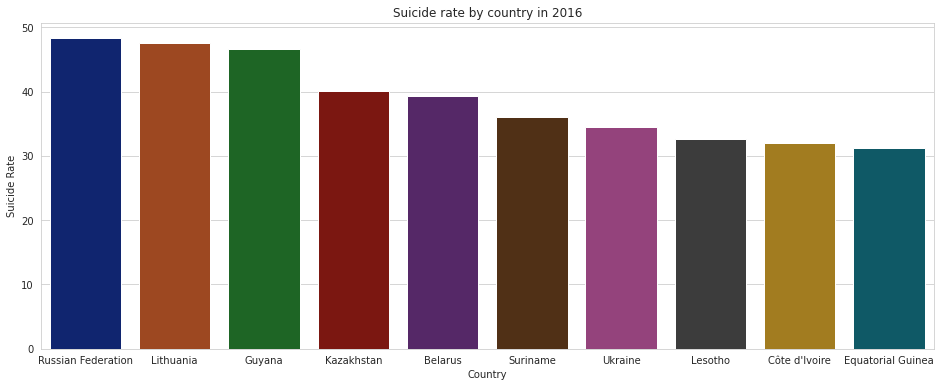

<Figure size 432x288 with 0 Axes>

In [92]:
# Pour le DF top10Suicide, on sélectionne la colonne Country et on récupère seulement les valeurs de cette colonne.
top10Country = top10Suicide.select("Country").rdd.flatMap(lambda x: x).collect()
# Pour le DF top10Suicide, on sélectionne la colonne Suicide_Rate et on récupère seulement les valeurs de cette colonne.
top10Suicide = top10Suicide.select("Suicide_Rate").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(16, 6))
sns.set_style('whitegrid')
sns.set_palette("dark")

sns.barplot(x=top10Country,
            y=top10Suicide,
            order=top10Suicide.sort(reverse=True))

plt.title('Suicide rate by country in 2016')
plt.xlabel('Country')
plt.ylabel('Suicide Rate')

plt.show()
plt.clf()

Le graphique ci-dessous, nous permet de mieux visualiser la répartition des suicides selon le sexe.
On peut constater que le suicide est plus commun chez les hommmes que chez les femmes. On répartie cette donnée selon les régions.

In [14]:
# Ici, on se concentre seulement sur la donnée de la France
france16 = data16.filter("Country == 'France'")
france16.show(truncate=False)

+-------+-----------+----+------------+
|Country|Sex        |Year|Suicide_Rate|
+-------+-----------+----+------------+
|France | Both sexes|2016|12.1        |
|France | Male      |2016|17.9        |
|France | Female    |2016|6.5         |
+-------+-----------+----+------------+



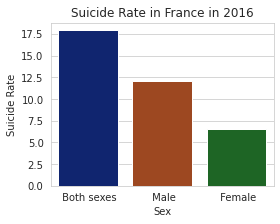

<Figure size 432x288 with 0 Axes>

In [85]:
france16Sex = france16.select("Sex").rdd.flatMap(lambda x: x).collect()
france16Suicide = france16.select("Suicide_Rate").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(4, 3))
sns.set_style('whitegrid')
sns.set_palette("dark")

sns.barplot(x=france16Sex,
        y=france16Suicide,
        order=france16Suicide.sort(reverse=True))

plt.title('Suicide Rate in France in 2016')
plt.xlabel('Sex')
plt.ylabel('Suicide Rate')

plt.show()
plt.clf()

## Happiness Dataset

In [16]:
# Les 10 pays les plus heureux
top3Region = spark.sql("SELECT * FROM HappinessData ORDER BY `Region` ASC LIMIT 10")
top3Region.show(truncate=False)

+--------------+--------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|Country       |Region                    |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+--------------+--------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|New Zealand   |Australia and New Zealand |8             |7.334          |7.264     |7.404 |1.36066              |1.17278|0.83096                   |0.58147   |
|Australia     |Australia and New Zealand |9             |7.313          |7.241     |7.385 |1.44443              |1.10476|0.8512                    |0.56837   |
|Moldova       |Central and Eastern Europe|55            |5.897          |5.823     |5.971 |0.69177              |0.83132|0.52309                   |0.25202   |
|Belarus       |Central and Easter

In [17]:
# Les 10 pays les plus heureux
top3Region = spark.sql("SELECT * FROM HappinessData ORDER BY `Region` ASC LIMIT 10")
top3Region.show(truncate=False)

+--------------+--------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|Country       |Region                    |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+--------------+--------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|New Zealand   |Australia and New Zealand |8             |7.334          |7.264     |7.404 |1.36066              |1.17278|0.83096                   |0.58147   |
|Australia     |Australia and New Zealand |9             |7.313          |7.241     |7.385 |1.44443              |1.10476|0.8512                    |0.56837   |
|Moldova       |Central and Eastern Europe|55            |5.897          |5.823     |5.971 |0.69177              |0.83132|0.52309                   |0.25202   |
|Belarus       |Central and Easter

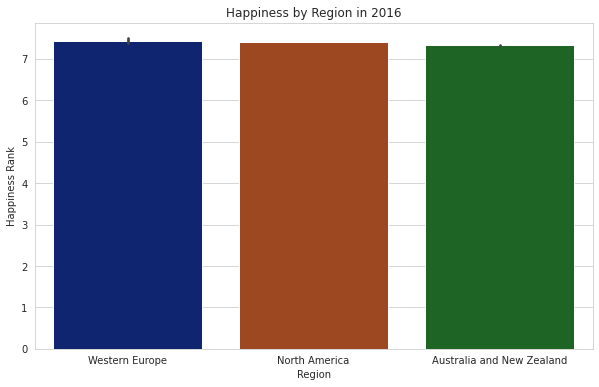

<Figure size 432x288 with 0 Axes>

In [83]:
top3HappinessRegion = top10Happiness.select("Region").rdd.flatMap(lambda x: x).collect()
top3HappinessRank = top10Happiness.select("Happiness_Rank").rdd.flatMap(lambda x: x).collect()
top3HappinessScore = top10Happiness.select("Happiness_Score").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette("dark")

sns.barplot(x=top3HappinessRegion,
            y=top3HappinessScore,
            order=top3HappinessRank.sort(reverse=True))

plt.title('Happiness by Region in 2016')
plt.xlabel('Region')
plt.ylabel('Happiness Rank')

plt.show()
plt.clf()

In [45]:
# Les 10 pays les plus heureux
top10Happiness = spark.sql("SELECT * FROM HappinessData ORDER BY `Happiness_Rank` ASC LIMIT 10")
top10Happiness.show()

+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|    Country|              Region|Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|    Denmark|      Western Europe|             1|          7.526|      7.46| 7.592|              1.44178|1.16374|                   0.79504|   0.57941|
|Switzerland|      Western Europe|             2|          7.509|     7.428|  7.59|              1.52733|1.14524|                   0.86303|   0.58557|
|    Iceland|      Western Europe|             3|          7.501|     7.333| 7.669|              1.42666|1.18326|                   0.86733|   0.56624|
|     Norway|      Western Europe|             4|          7.498|     7.421| 7.575|     

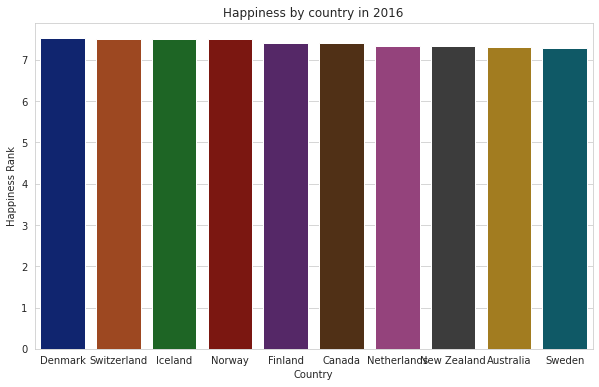

<Figure size 432x288 with 0 Axes>

In [84]:
top10HappinessCountry = top10Happiness.select("Country").rdd.flatMap(lambda x: x).collect()
top10HappinessRank = top10Happiness.select("Happiness_Rank").rdd.flatMap(lambda x: x).collect()
top10HappinessScore = top10Happiness.select("Happiness_Score").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette("dark")

sns.barplot(x=top10HappinessCountry,
            y=top10HappinessScore,
            order=top10HappinessRank.sort(reverse=True))

plt.title('Happiness by country in 2016')
plt.xlabel('Country')
plt.ylabel('Happiness Rank')

plt.show()
plt.clf()

In [109]:
filter2 = dfJoin['Happiness_Score']<4.5
unhappy_countries = dfJoin[filter2]
unhappy_countries.Region.value_counts()

Sub-Saharan Africa                 79
Central and Eastern Europe         12
Southern Asia                       9
Middle East and Northern Africa     7
Southeastern Asia                   6
Latin America and Caribbean         3
Name: Region, dtype: int64

Text(0.5, 1.0, 'Distribution of the Least Happy Countries by Region')

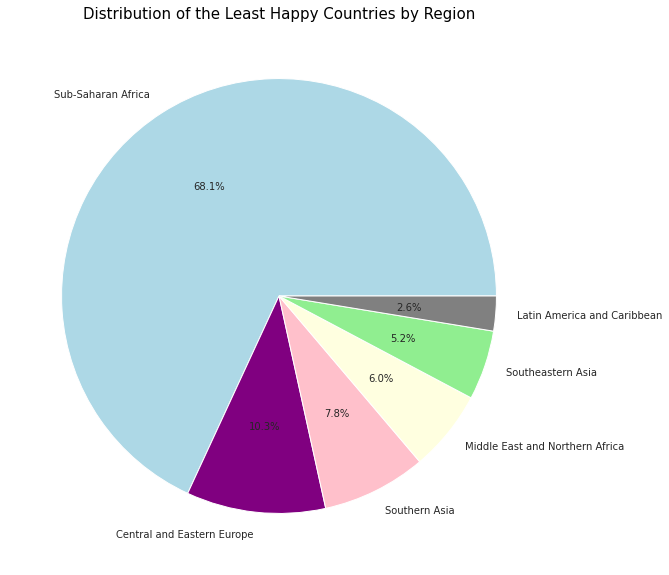

In [111]:
labels = unhappy_countries.Region.value_counts().index
colors = ['lightblue','purple','pink','lightyellow','lightgreen','grey']
sizes = unhappy_countries.Region.value_counts().values

plt.figure(figsize = (10,10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of the Least Happy Countries by Region',color = 'Black',fontsize = 15)

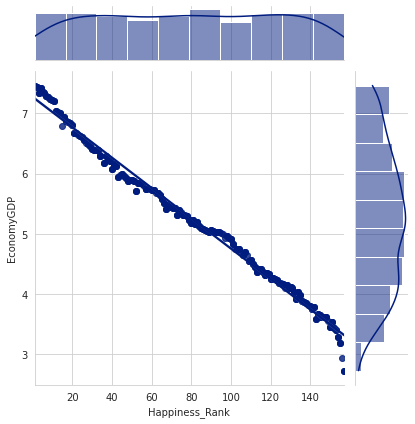

In [112]:
sns.jointplot(x='Happiness_Rank', y='EconomyGDP',data=dfJoin, kind="reg")

Grâce au **piechart** et au **joint plot** nous pouvons donc dire que les pays les moins heureux sont ceux avec un faible PIB (economyGDP). La corrélation est effectivement forte et évidente. D'abord pointé du doigt par le piechart, elle est ensuite souligné avec cette regression.

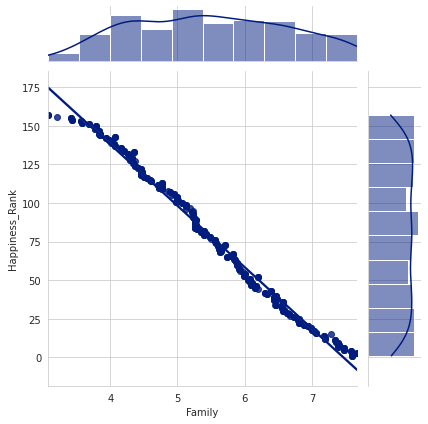

In [124]:
sns.jointplot(x='Family', y='Happiness_Rank',data=dfJoin, kind="reg")

Cette régression nous permet d'affirmer que plus le rang de bohneur du pays est faible, plus la famille sera importante. En effet le malheur peut être combler par l'arriver d'un heureux évènement : la naissance d'un enfant.

In [114]:
# L'argent ne fait pas le bonheur ?
spark.sql("SELECT * FROM HappinessData ORDER BY `EconomyGDP` DESC").show(8)

+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|    Country|              Region|Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|    Denmark|      Western Europe|             1|          7.526|      7.46| 7.592|              1.44178|1.16374|                   0.79504|   0.57941|
|Switzerland|      Western Europe|             2|          7.509|     7.428|  7.59|              1.52733|1.14524|                   0.86303|   0.58557|
|     Norway|      Western Europe|             4|          7.498|     7.421| 7.575|              1.57744| 1.1269|                   0.79579|   0.59609|
|    Finland|      Western Europe|             5|          7.413|     7.351| 7.475|     

In [49]:
# Trust issues? Un facteur plutôt important
spark.sql("SELECT * FROM HappinessData ORDER BY Trust_GovernmentCorruption DESC").show(8)

+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|    Country|              Region|Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+-----------+--------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|  Hong Kong|        Eastern Asia|            75|          5.458|     5.362| 5.554|               1.5107|0.87021|                   0.95277|   0.48079|
|  Singapore|   Southeastern Asia|            22|          6.739|     6.674| 6.804|              1.64555|0.86758|                   0.94719|    0.4877|
|      Japan|        Eastern Asia|            53|          5.921|      5.85| 5.992|              1.38007|1.06054|                   0.91491|   0.46761|
|South Korea|        Eastern Asia|            57|          5.835|     5.747| 5.923|     

In [50]:
# Famille avant tout
spark.sql("SELECT * FROM HappinessData ORDER BY Family DESC").show(8, truncate=False)

+-----------+-------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|Country    |Region                   |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+-----------+-------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|Iceland    |Western Europe           |3             |7.501          |7.333     |7.669 |1.42666              |1.18326|0.86733                   |0.56624   |
|Denmark    |Western Europe           |1             |7.526          |7.46      |7.592 |1.44178              |1.16374|0.79504                   |0.57941   |
|Switzerland|Western Europe           |2             |7.509          |7.428     |7.59  |1.52733              |1.14524|0.86303                   |0.58557   |
|Norway     |Western Europe           |4             |7.49

In [51]:
# On sélectionne simplement la ligne qui correspond à la France
spark.sql("SELECT * FROM HappinessData WHERE Country == 'France'").show(truncate=False)

+-------+--------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|Country|Region        |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|
+-------+--------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+
|France |Western Europe|32            |6.478          |6.397     |6.559 |1.39488              |1.00508|0.83795                   |0.46562   |
+-------+--------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+



## Corrélation entre les deux dataset

<AxesSubplot:>

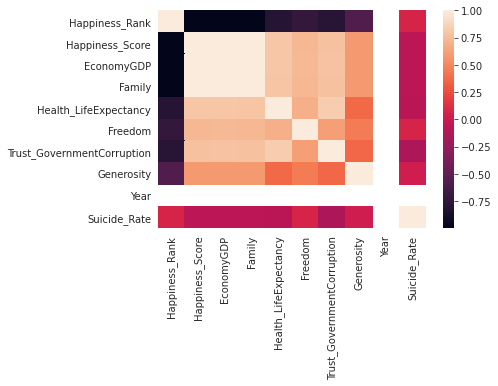

In [123]:
sns.heatmap(dfJoin.corr())

#### Ranking des critères importants :

- 1 EconomyGDP
- 2 Health_LifeExpectancy
- 3 Family 
- 4 Freedom
- 6 Trust_Governement
- 7 Generosity

On peut voir que le le taux de suicide a légèrement baissé grâce au **Happiness Rank**, la **Family**, et le **Freedom**.

In [135]:
top10SuicideRegion = spark.sql("SELECT * FROM joinDataT ORDER BY Suicide_Rate DESC LIMIT 10")
top10SuicideRegion.show(truncate=False)

+----------+---------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+----------+-----------+----+------------+
|Country   |Region                     |Happiness_Rank|Happiness_Score|EconomyGDP|Family|Health_LifeExpectancy|Freedom|Trust_GovernmentCorruption|Generosity|Country   |Sex        |Year|Suicide_Rate|
+----------+---------------------------+--------------+---------------+----------+------+---------------------+-------+--------------------------+----------+----------+-----------+----+------------+
|Lithuania |Central and Eastern Europe |60            |5.813          |5.734     |5.892 |1.2692               |1.06411|0.64674                   |0.18929   |Lithuania | Male      |2016|47.5        |
|Kazakhstan|Central and Eastern Europe |54            |5.919          |5.837     |6.001 |1.22943              |0.95544|0.57386                   |0.4052    |Kazakhstan| Male      |2016|40.1        |
|Bela

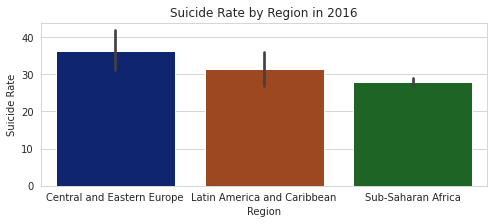

<Figure size 432x288 with 0 Axes>

In [136]:
top10Region = top10SuicideRegion.select("Region").rdd.flatMap(lambda x: x).collect()
top10SuicideRateRegion = top10SuicideRegion.select("Suicide_Rate").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(8, 3))
sns.set_style('whitegrid')
sns.set_palette("dark")

sns.barplot(x=top10Region,
            y=top10SuicideRateRegion,
            order=top10SuicideRateRegion.sort(reverse=True))

plt.title('Suicide Rate by Region in 2016')
plt.xlabel('Region')
plt.ylabel('Suicide Rate')
plt.show()
plt.clf()

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWa

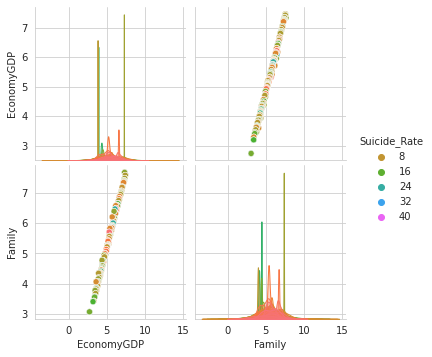

<Figure size 432x288 with 0 Axes>

In [59]:
sns.pairplot(data=dfJoin,
        vars=["EconomyGDP", "Family"],
        kind='scatter',
        hue='Suicide_Rate',
        palette='husl')

plt.show()
plt.clf()

On peut remarquer qu'il y a une **légère corrélation** entre l'economie et la famille. Effectivement on peut noter que plus l'economie est forte, plus la famille augmente. Ce qui semble logique dans la mesure où, plus on a de pouvoir d'achat, plus on est apte à s'occuper d'une grande famille.

  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/se

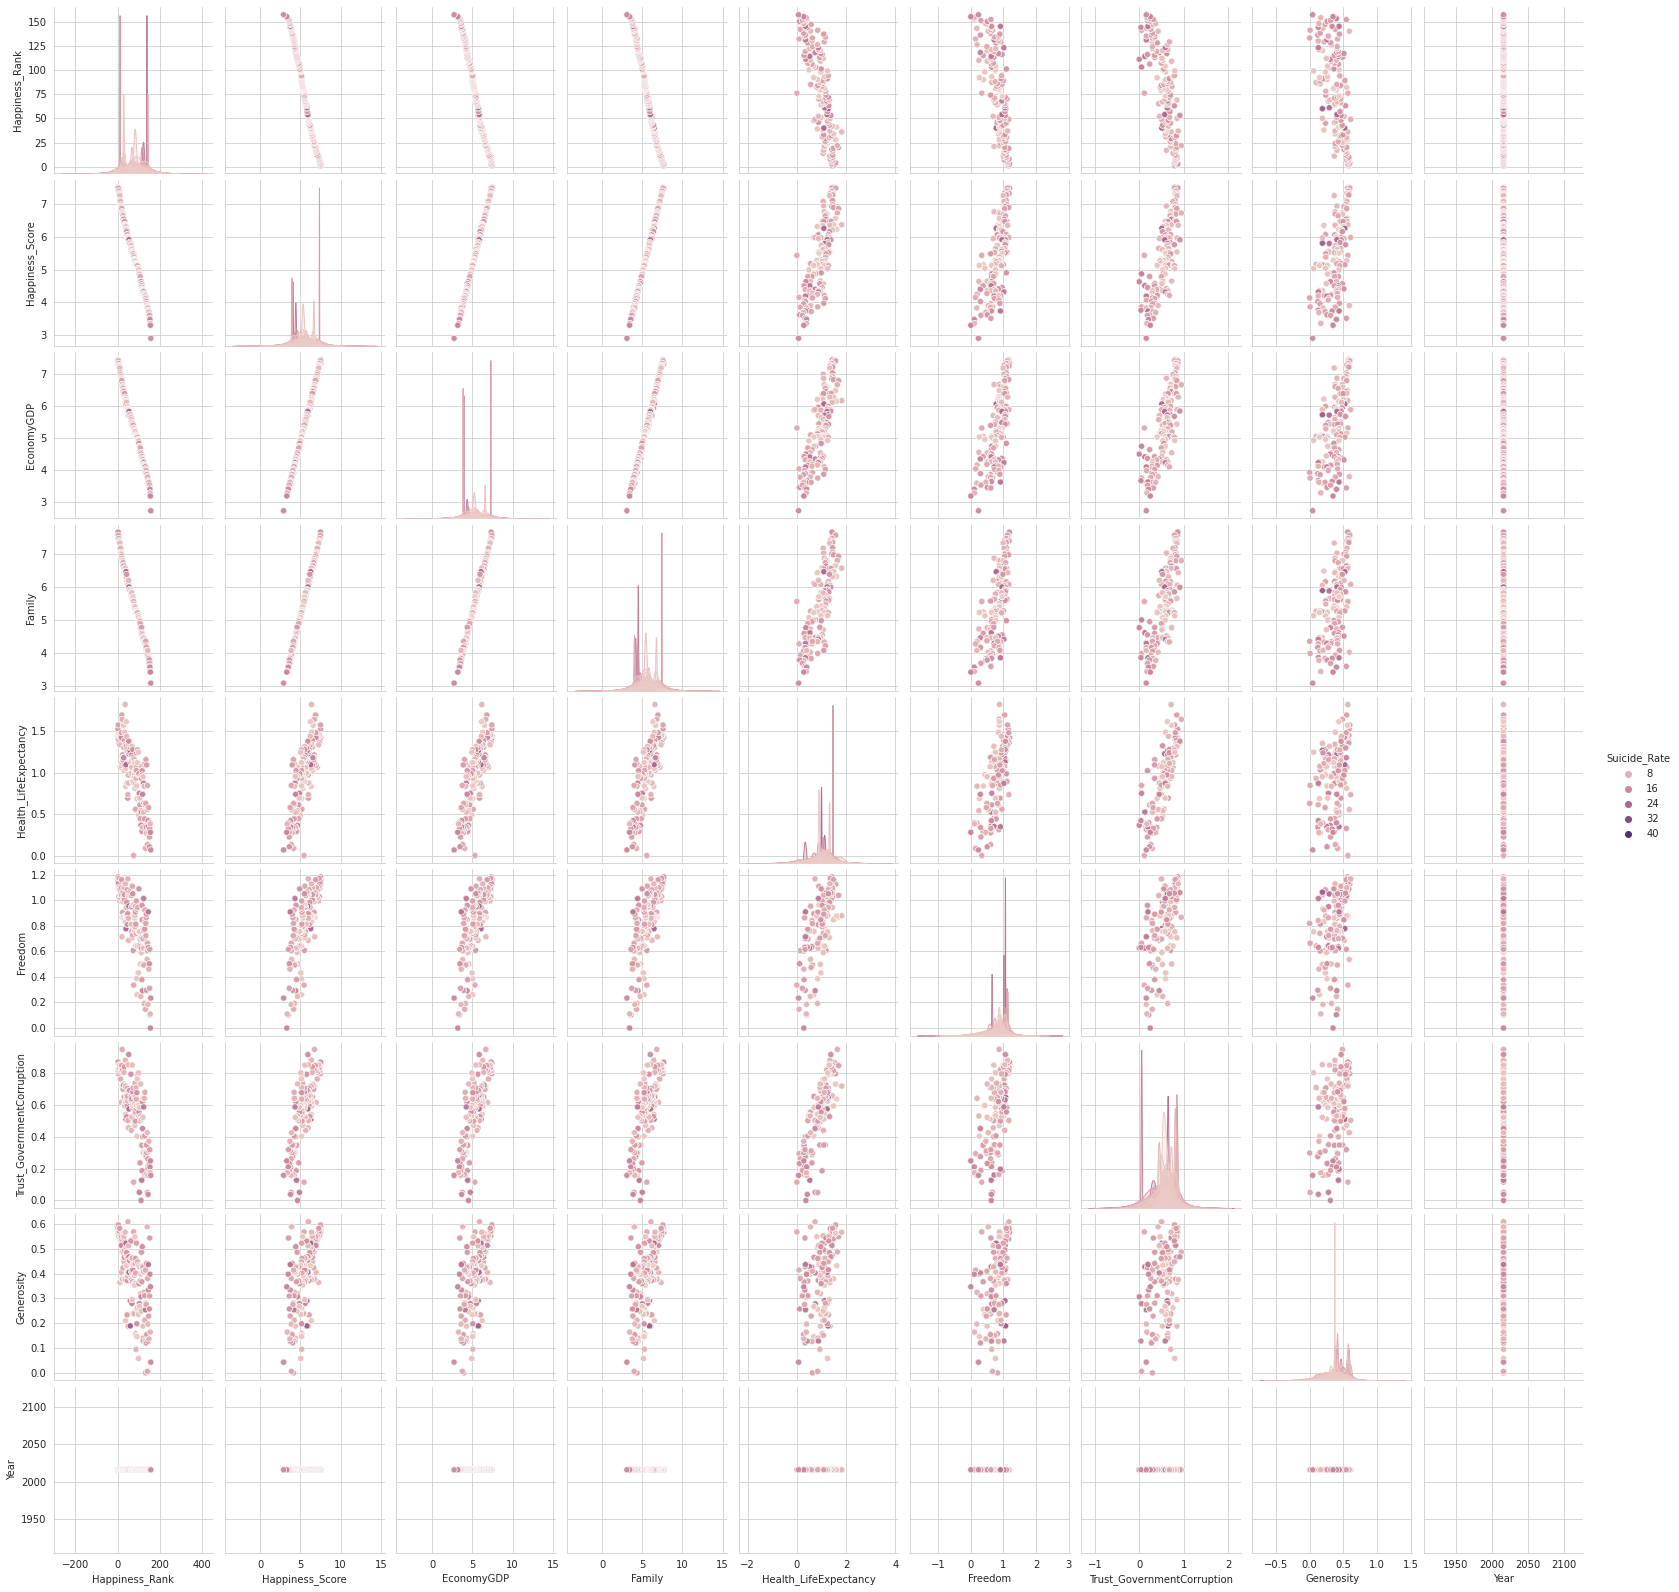

In [60]:
sns.pairplot(dfJoin, hue="Suicide_Rate")

Grâce à ce **pairplot**  qui nous donne une vision d'ensemble, on peut donc confirmer les **liens de corrélations et de non-corrélations** observer au-dessus à l'aide des différents graphiques.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=64f110ed-39ab-4fb7-aa55-e11ea6383245' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>